In [1]:
import gc
import os
import re
import torch
import warnings
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image

In [2]:
warnings.filterwarnings("ignore")

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if str(device) == "cuda":
    print(f"Using GPU {torch.cuda.get_device_properties(device)}")
else:
    print("Using CPU")

Using GPU _CudaDeviceProperties(name='NVIDIA GeForce RTX 4090', major=8, minor=9, total_memory=24563MB, multi_processor_count=128, uuid=60c52120-6906-b8a0-9818-13401561e581, L2_cache_size=72MB)


In [4]:
def empty_cache() -> None:
    # Cleaning out the device cache
    gc.collect()
    torch.cuda.empty_cache()


def print_free_memory() -> None:
    free, total = torch.cuda.mem_get_info(device)
    print(f"Percent of free memory: {round(free/total *100,2)}")


empty_cache()
print_free_memory()

Percent of free memory: 93.61


In [5]:
def memory_summary() -> None:
    print(torch.cuda.memory_summary())


memory_summary()

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |

In [6]:
# For AMD GPU - 7800xt
device_name = torch.cuda.get_device_name(0)
if "AMD" in device_name or "Radeon" in device_name:
    os.environ["HSA_OVERRIDE_GFX_VERSION"] = "11.0.0"

print(f"GPU {torch.cuda.get_device_properties(device).name} is now setup")

GPU NVIDIA GeForce RTX 4090 is now setup


In [73]:
current_directory = os.getcwd()
path_to_base_directory = re.search(rf"(.*?){"Weird-Stuff-In-Traffic"}", current_directory).group(1)

image_folder = path_to_base_directory + f"Weird-Stuff-In-Traffic/Data/yolo/nuScenes/images/val"
label_folder = path_to_base_directory + f"Weird-Stuff-In-Traffic/Data/yolo/nuScenes/labels/val"
model_path = path_to_base_directory + f"Weird-Stuff-In-Traffic/Models/Generation/yolo/best_weights.pt" # Pfad anpassen

dice_scores = []
iou_scores = []

for image_file_name in os.listdir(image_folder):

    # Load Image
    image = Image.open(image_folder+"/"+image_file_name)
    width, height = image.size

    # Load Label
    with open(label_folder+ "/" + image_file_name[:-3] + "txt", 'r') as f:
        parts = f.read().split()
    coords = np.array([float(x) for x in parts[1:]]).reshape(-1, 2)
    coords[:,0] *= width
    coords[:,1] *= height
    polygon = coords.astype(np.int32)
    
    mask_gt = np.zeros((height, width), dtype=np.uint8)
    cv2.fillPoly(mask_gt, [polygon], 1)

    # Get model output
    model = YOLO(model_path)
    prediction = model(image)[0]
    
    mask_pred_raw = prediction.masks.data[0].cpu().numpy().astype(np.uint8)  # Werte 0 oder 1
    
    mask_pred_up = cv2.resize(
        mask_pred_raw,
        (width, height),
        interpolation=cv2.INTER_NEAREST
    )
    
    mask_pred_bool = mask_pred_up == 1
    
    # Dice-Score
    intersection = np.logical_and(mask_gt == 1, mask_pred_bool).sum()
    union        = mask_gt.sum() + mask_pred_bool.sum()
    dice_score   = 2 * intersection / union
    dice_scores.append(dice_score)

    # IoU-Score
    union = np.logical_or(mask_gt == 1, mask_pred_bool).sum()
    iou   = intersection / union
    iou_scores.append(iou)

print()
dice_mean = np.mean(dice_scores)
print(f"Dice: {dice_mean:.4f}")

iou_mean = np.mean(iou_scores)
print(f"IoU: {iou_mean:.4f}")


0: 160x256 1 street, 6.0ms
Speed: 0.9ms preprocess, 6.0ms inference, 1.8ms postprocess per image at shape (1, 3, 160, 256)

0: 160x256 1 street, 5.9ms
Speed: 0.4ms preprocess, 5.9ms inference, 1.6ms postprocess per image at shape (1, 3, 160, 256)

0: 160x256 1 street, 6.3ms
Speed: 0.3ms preprocess, 6.3ms inference, 1.6ms postprocess per image at shape (1, 3, 160, 256)

0: 160x256 1 street, 6.3ms
Speed: 0.3ms preprocess, 6.3ms inference, 1.6ms postprocess per image at shape (1, 3, 160, 256)
Dice: 0.8723
IoU: 0.7758


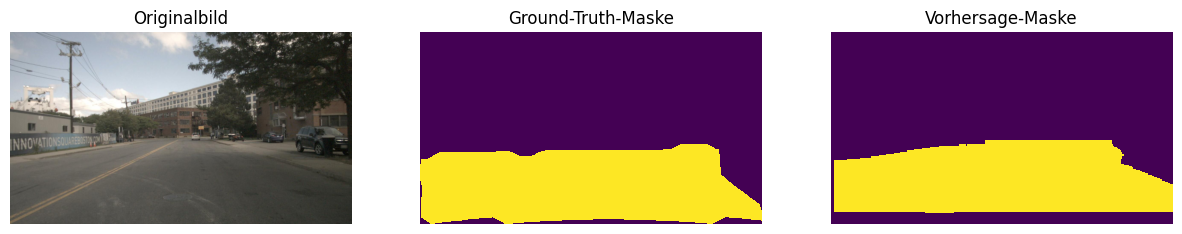

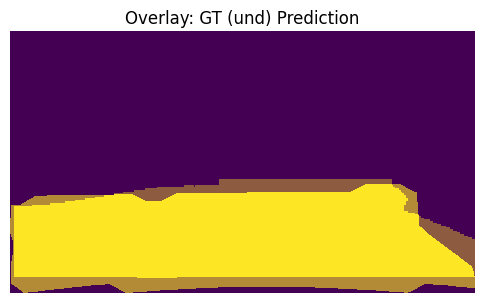

In [63]:
%matplotlib inline

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

image_path = path_to_base_directory + f"Weird-Stuff-In-Traffic/Data/yolo/nuScenes/images/val/n008-2018-08-27-11-48-51-0400__CAM_FRONT__1535385034612404.png"
axes[0].imshow(Image.open(image_path))
axes[0].set_title("Originalbild")
axes[0].axis("off")

axes[1].imshow(mask_gt, interpolation="nearest")
axes[1].set_title("Ground-Truth-Maske")
axes[1].axis("off")

axes[2].imshow(mask_pred_up, interpolation="nearest")
axes[2].set_title("Vorhersage-Maske")
axes[2].axis("off")

fig2, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(mask_gt, interpolation="nearest")
ax.imshow(mask_pred_up, alpha=0.4, interpolation="nearest")
ax.set_title("Overlay: GT (und) Prediction")
ax.axis("off")

plt.show()